In [10]:
! pip install -q kaggle
! pip install -q keras_cv
import os

!mkdir ~/.kaggle

if not os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json')):
  from google.colab import files
  print("Upload kaggle.json here")
  files.upload()

!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.2 MB/s eta 0:00:00
Upload kaggle.json here


Saving kaggle.json to kaggle.json


In [11]:
dataset_name = 'pkdarabi/medical-image-dataset-brain-tumor-detection'
zip_name = dataset_name.split('/')[-1]

!kaggle datasets download -d {dataset_name} --force
!unzip -o -q ./{zip_name}.zip -d .

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection
License(s): Attribution 4.0 International (CC BY 4.0)
 88% 49.0M/55.6M [00:00<00:00, 76.8MB/s]
100% 55.6M/55.6M [00:00<00:00, 75.2MB/s]


I have used the following methods.

* I have implemented YOLOV8 model stemmed from this Keras example[1,2],
* Used tf.data for input pipeline,
* I created txt file parser function,

## My Another Segmentation Projects

* [Sport Scene Classification w/ViT (3 KFold CV)](https://www.kaggle.com/code/banddaniel/sport-scene-classification-w-vit-3-kfold-cv)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Brain Tumor Segmentation (detectron2, mAP@50:76.2)](https://www.kaggle.com/code/banddaniel/brain-tumor-segmentation-detectron2-map-50-76-2)

## References
1. https://keras.io/examples/vision/yolov8/
2. Reis, D., Kupec, J., Hong, J., & Daoudi, A. (2023). Real-Time Flying Object Detection with YOLOv8 (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2305.09972

In [12]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import keras_cv


BATCH_SIZE = 32
GLOBAL_CLIPNORM = 10.0

AUTO = tf.data.AUTOTUNE

Using TensorFlow backend


# <span style="color:#e74c3c;"> </span> Preprocessing

In [13]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')

    boxes = []
    classes = []

    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])

            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])

            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)

            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)

    return img_path, classes, boxes


# a function for creating file paths list
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path


class_ids = ['label0', 'label1', 'label2']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

class_mapping

{0: 'label0', 1: 'label1', 2: 'label2'}

In [14]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):

    img_files = sorted(create_paths_list(img_files_paths))
    annot_files = sorted(create_paths_list(annot_files_paths))

    image_paths = []
    bbox = []
    classes = []

    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)

    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bbox

In [15]:
# applying functions
train_img_paths, train_classes, train_bboxes = creating_files('Brain Tumor Detection/train/images',
                                                              'Brain Tumor Detection/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files('Brain Tumor Detection/valid/images',
                                                              'Brain Tumor Detection/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('Brain Tumor Detection/test/images',
                                                            'Brain Tumor Detection/test/labels')

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [16]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32)

    return img

noise = keras_cv.layers.JitteredResize(
    target_size=(128, 128),
    scale_factor=(1, 1.5),
    bounding_box_format="xyxy",
)

resizing = keras_cv.layers.Resizing(
    192,
    192,
    pad_to_aspect_ratio=True,
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }

    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [17]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls=AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder=True)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls=AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls=AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [18]:
# a function to visualize samples from a dataset

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

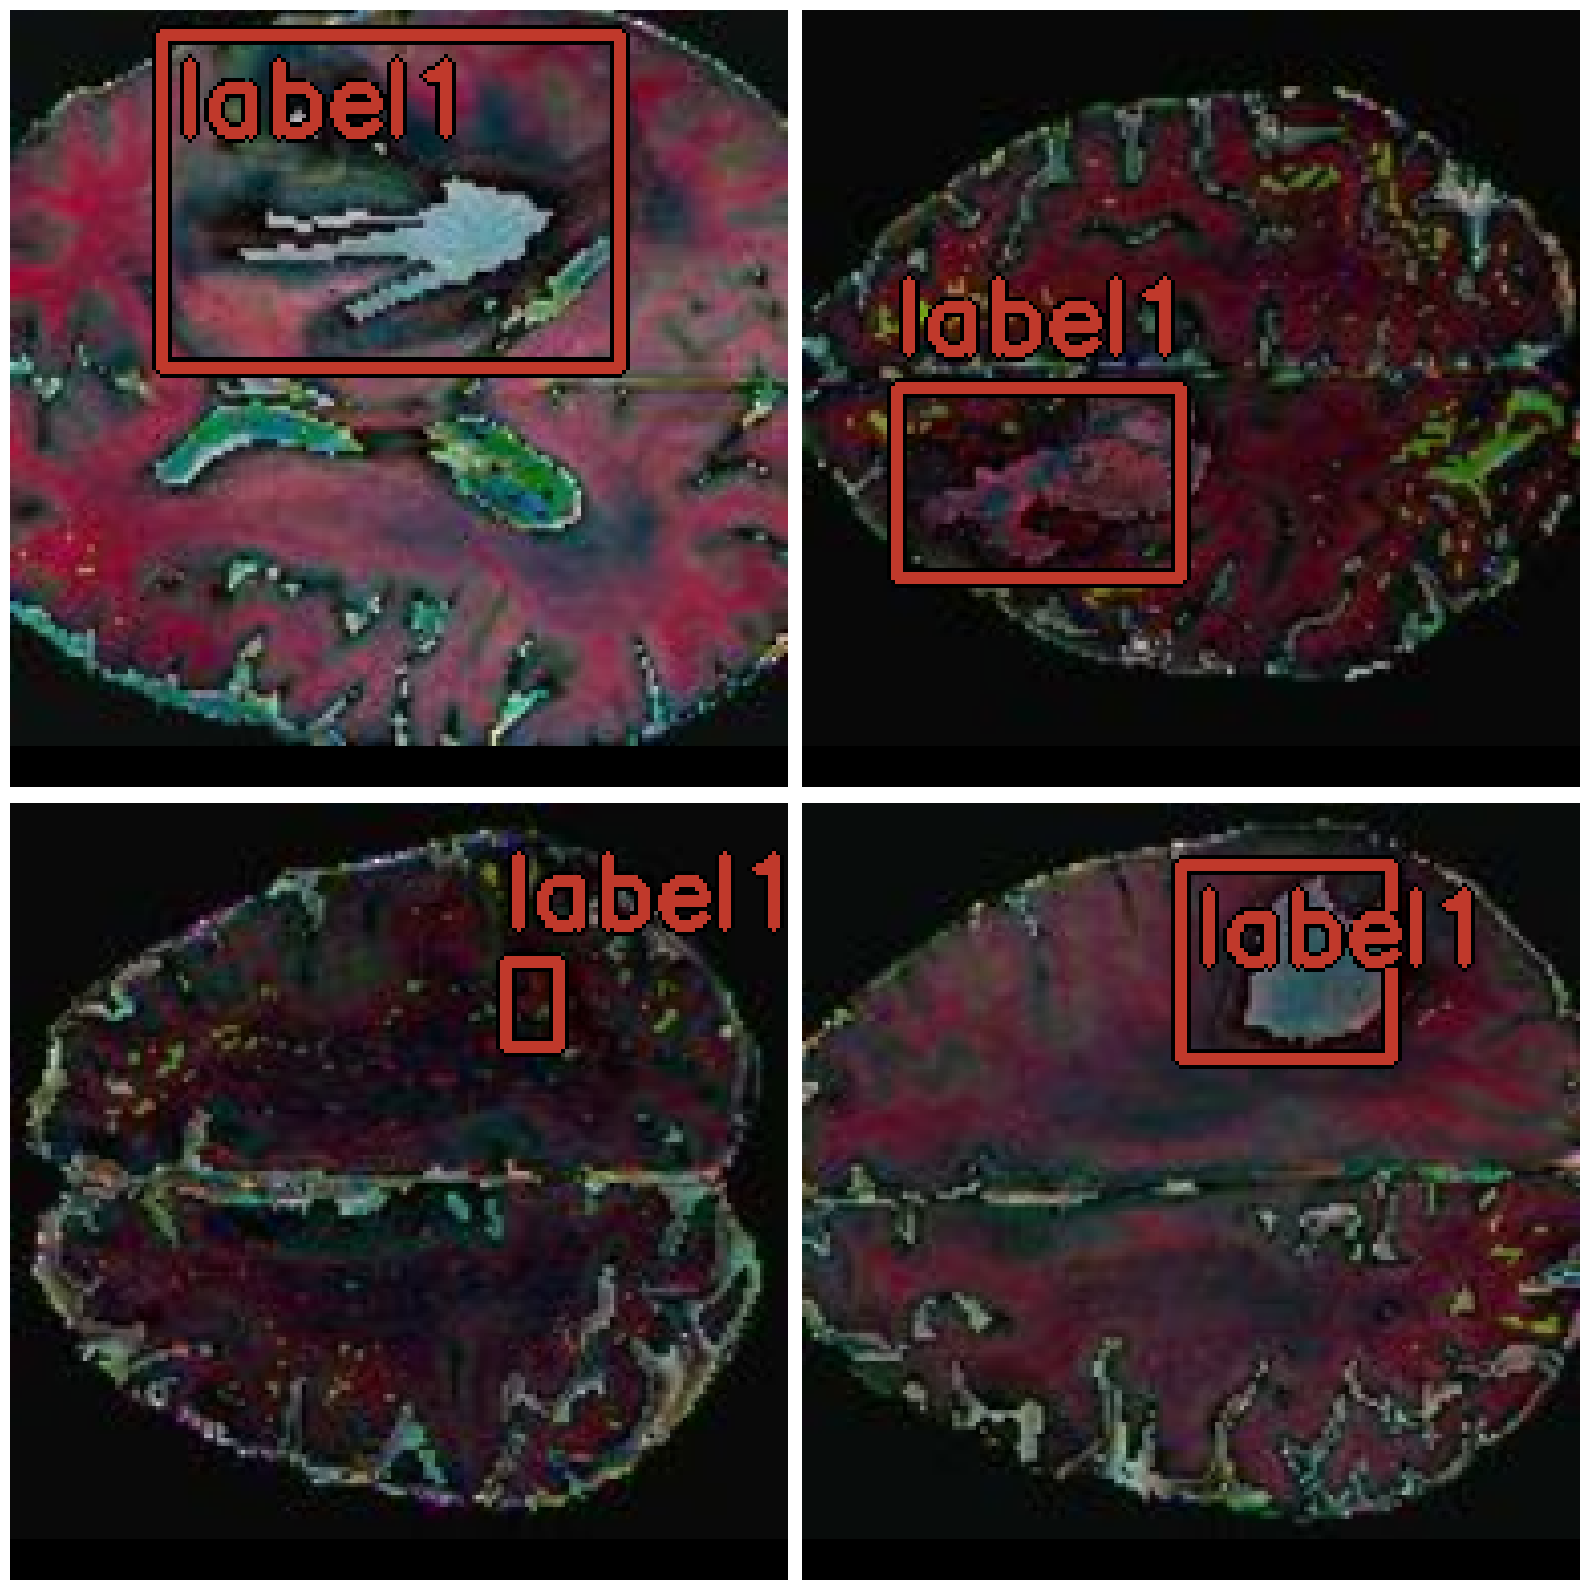

In [19]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# <span style="color:#e74c3c;"> YOLO V8</span> Model

In [20]:
# creating mirrored strategy

stg = tf.distribute.MirroredStrategy()

In [21]:
from keras.callbacks           import ReduceLROnPlateau
from keras.callbacks           import EarlyStopping
# creating pre-trained model backbone with coco weights

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                            patience=3, verbose=1, mode='min',
                                            min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                           mode='min', restore_best_weights=True)

with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")

    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                              bounding_box_format="xyxy",
                                              backbone=backbone, fpn_depth=1)

    optimizer = AdamW(#learning_rate=0.0001,
                      #weight_decay=0.004,
                      global_clipnorm=GLOBAL_CLIPNORM
                      )

    YOLOV8_model.compile(optimizer=optimizer, classification_loss='binary_crossentropy', box_loss='ciou')

100%|██████████| 645/645 [00:00<00:00, 351kB/s]
100%|██████████| 5.11M/5.11M [00:00<00:00, 20.5MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [22]:
model_path = f'{os.getcwd()}/yolo_tmp.keras'

In [23]:
YOLOV8_model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


# <span style="color:#e74c3c;"> Training </span>

In [24]:
if 'YOLOV8_model' not in locals():
  YOLOV8_model =  models.load_model(model_path)

In [30]:
from warnings import filterwarnings

class EvaluateCOCOMetricsCallback(callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0
        filterwarnings('ignore')

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [31]:
hist = YOLOV8_model.fit(train_dataset, validation_data=valid_dataset, epochs=50, callbacks=[learning_rate_reduction, early_stop, EvaluateCOCOMetricsCallback(valid_dataset, "model.tf")])

Epoch 1/50
216/216 [==============================] - 93s 431ms/step - loss: 1.8435 - box_loss: 1.4419 - class_loss: 0.4016 - val_loss: 2.2850 - val_box_loss: 1.7905 - val_class_loss: 0.4945 - lr: 0.0010 - MaP: 0.2006 - MaP@[IoU=50]: 0.4043 - MaP@[IoU=75]: 0.1793 - MaP@[area=small]: 0.0122 - MaP@[area=medium]: 0.2331 - MaP@[area=large]: 0.2497 - Recall@[max_detections=1]: 0.2431 - Recall@[max_detections=10]: 0.2513 - Recall@[max_detections=100]: 0.2513 - Recall@[area=small]: 0.0293 - Recall@[area=medium]: 0.2983 - Recall@[area=large]: 0.2674
Epoch 2/50
216/216 [==============================] - 87s 405ms/step - loss: 1.7908 - box_loss: 1.4026 - class_loss: 0.3883 - val_loss: 2.2281 - val_box_loss: 1.7518 - val_class_loss: 0.4763 - lr: 0.0010 - MaP: 0.2227 - MaP@[IoU=50]: 0.4322 - MaP@[IoU=75]: 0.2066 - MaP@[area=small]: 0.0167 - MaP@[area=medium]: 0.2507 - MaP@[area=large]: 0.3123 - Recall@[max_detections=1]: 0.2731 - Recall@[max_detections=10]: 0.2838 - Recall@[max_detections=100]: 0.

In [32]:
history_path = f'{os.getcwd()}/history_tmp.keras'

In [33]:
np.save(history_path, hist.history)

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

dict_keys(['loss', 'box_loss', 'class_loss', 'val_loss', 'val_box_loss', 'val_class_loss', 'lr', 'MaP', 'MaP@[IoU=50]', 'MaP@[IoU=75]', 'MaP@[area=small]', 'MaP@[area=medium]', 'MaP@[area=large]', 'Recall@[max_detections=1]', 'Recall@[max_detections=10]', 'Recall@[max_detections=100]', 'Recall@[area=small]', 'Recall@[area=medium]', 'Recall@[area=large]'])


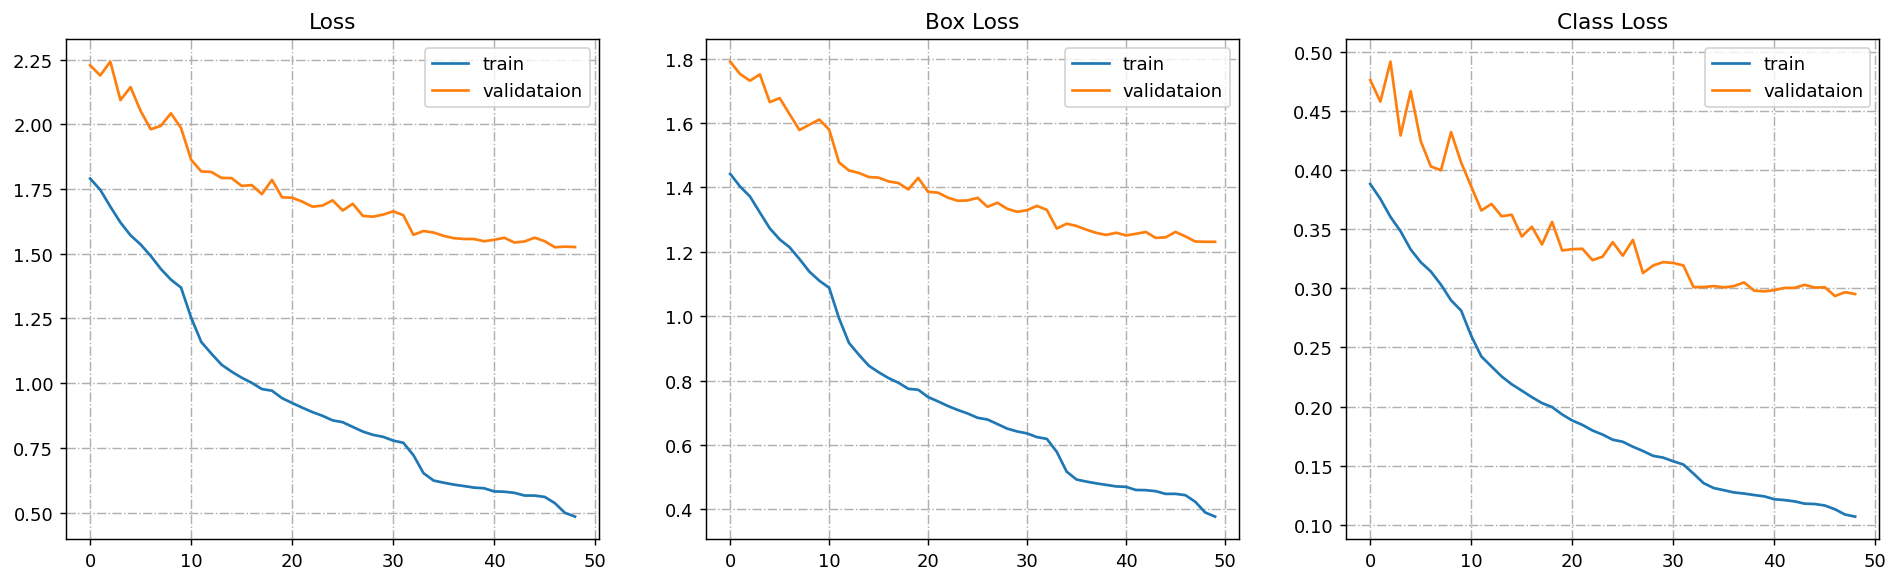

In [37]:
fig1, axs1 = plt.subplots(1,3, figsize = (18,5), dpi = 130)

print(hist.history.keys())

axs1[0].grid(linestyle="dashdot")
axs1[0].set_title("Loss")
axs1[0].plot(hist.history['loss'][1:])
axs1[0].plot(hist.history['val_loss'][1:])
axs1[0].legend(["train", "validataion"])

axs1[1].grid(linestyle="dashdot")
axs1[1].set_title("Box Loss")
axs1[1].plot(hist.history['box_loss'])
axs1[1].plot(hist.history['val_box_loss'])
axs1[1].legend(["train",  "validataion"])

axs1[2].grid(linestyle="dashdot")
axs1[2].set_title("Class Loss")
axs1[2].plot(hist.history['class_loss'][1:])
axs1[2].plot(hist.history['val_class_loss'][1:])
axs1[2].legend(["train",  "validataion"])

fig3, axs3 = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs3[0].grid(linestyle="dashdot")
axs3[0].set_title("Learning Rate")
axs3[0].plot(hist.history['lr'][1:])
axs3[0].plot(hist.history['val_lr'][1:])
axs3[0].legend(["train",  "validataion"])

fig2, axs2 = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs2[0].grid(linestyle="dashdot")
axs2[0].set_title("MaP")
axs2[0].plot(hist.history['accuracy'][1:])
axs2[0].plot(hist.history['val_accuracy'][1:])
axs2[0].legend(["train",  "validataion"])

axs2[1].grid(linestyle="dashdot")
axs2[1].set_title("Accuracy")
axs2[1].plot(hist.history['accuracy'][1:])
axs2[1].plot(hist.history['val_accuracy'][1:])
axs2[1].legend(["train",  "validataion"])

axs2[2].grid(linestyle="dashdot")
axs2[2].set_title("Accuracy")
axs2[2].plot(hist.history['accuracy'][1:])
axs2[2].plot(hist.history['val_accuracy'][1:])
axs2[2].legend(["train",  "validataion"])

'lr',
 'MaP', 'MaP@[IoU=50]', 'MaP@[IoU=75]',
 'MaP@[area=small]', 'MaP@[area=medium]', 'MaP@[area=large]',
 'Recall@[max_detections=1]', 'Recall@[max_detections=10]',
 'Recall@[max_detections=100]', 'Recall@[area=small]', 'Recall@[area=medium]', 'Recall@[area=large]'

# <span style="color:#e74c3c;"> Test </span> Predictions

In [ ]:
if 'YOLOV8_model' not in locals():
  YOLOV8_model =  models.load_model(model_path)

In [ ]:
def join_batches(batches):
    all_images = tf.concat([images for images,_ in batches], axis=0)
    all_classes = tf.concat([labels['classes'] for _,labels in batches], axis=0)
    all_boxes = tf.concat([labels['boxes'] for _,labels in batches], axis=0)

    return all_images, { 'classes': all_classes, 'boxes': all_boxes }

images, y_true = join_batches(test_dataset.take(-1))

In [ ]:
y_pred = YOLOV8_model.predict(images)
y_pred = keras_cv.bounding_box.to_ragged(y_pred)

In [ ]:
def visualize_predict_detections(images, y_true, y_pred, cols, rows, bounding_box_format):
    print("############################# Padrão Ouro #############################")
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        true_color = (192, 57, 43),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=rows,
        cols=cols,
        show=True,
        class_mapping=class_mapping,
    )

    print("############################# Previsto #############################")
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_pred=y_pred,
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=rows,
        cols=cols,
        show=True,
        class_mapping=class_mapping,
    )

    print("############################# Sobreposição #############################")
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=rows,
        cols=cols,
        show=True,
        class_mapping=class_mapping,
    )

def preview_labels(y_set, idx):
    classes = tf.gather(y_set['classes'], idx)
    boxes = tf.gather(y_set['boxes'], idx)

    return { 'classes': classes, 'boxes': boxes }

In [ ]:
inicio = 10
fim = 20
rows = 1
cols = 4
idx = tf.constant(range(inicio, fim))

preview_images = tf.gather(images, idx)
preview_y_true = preview_labels(y_true, idx)
preview_y_pred = preview_labels(y_pred, idx)

visualize_predict_detections(preview_images, preview_y_true, preview_y_pred, cols, rows, bounding_box_format="xyxy")